# Uncertainty Sampling on the Radio Galaxy Zoo

In [9]:
import sys

import h5py, numpy, sklearn.neighbors
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt

sys.path.insert(1, '..')
import crowdastro.train, crowdastro.test

TRAINING_H5_PATH = '../training.h5'
CROWDASTRO_H5_PATH = '../crowdastro.h5'
NORRIS_DAT_PATH = '../data/norris_2006_atlas_classifications_ra_dec_only.dat'
CLASSIFIER_OUT_PATH = '../classifier.pkl'
ASTRO_TRANSFORMER_OUT_PATH = '../astro_transformer.pkl'
IMAGE_TRANSFORMER_OUT_PATH = '../image_transformer.pkl'
IMAGE_SIZE = 200 * 200
ARCMIN = 1 / 60
N_JOBS = 8

%matplotlib inline

In [10]:
# Load labels.
with h5py.File(TRAINING_H5_PATH, 'r') as training_h5:
    crowdsourced_labels = training_h5['labels'].value

with h5py.File(CROWDASTRO_H5_PATH, 'r') as crowdastro_h5:
    ir_names = crowdastro_h5['/wise/cdfs/string'].value
    ir_positions = crowdastro_h5['/wise/cdfs/numeric'].value[:, :2]
ir_tree = sklearn.neighbors.KDTree(ir_positions)

with open(NORRIS_DAT_PATH, 'r') as norris_dat:
    norris_coords = [r.strip().split('|') for r in norris_dat]

norris_labels = numpy.zeros((len(ir_positions)))
for ra, dec in norris_coords:
    # Find a neighbour.
    skycoord = SkyCoord(ra=ra, dec=dec, unit=('hourangle', 'deg'))
    ra = skycoord.ra.degree
    dec = skycoord.dec.degree
    ((dist,),), ((ir,),) = ir_tree.query([(ra, dec)])
    if dist < 0.1:
        norris_labels[ir] = 1

In [59]:
def train_and_test(hidden_atlas_training_indices):
    """
    hidden_atlas_training_indices: ATLAS indices to hide.
    """
    with h5py.File(TRAINING_H5_PATH, 'r') as training_h5, h5py.File(CROWDASTRO_H5_PATH, 'r') as crowdastro_h5:
        n_static = 5 if training_h5.attrs['ir_survey'] == 'wise' else 6
        train_indices = training_h5['is_ir_train'].value
        atlas_train_indices = training_h5['is_atlas_train'].value
        
        # Remove all IR objects near hidden ATLAS objects.
        for atlas_index in hidden_atlas_training_indices:
            ir = crowdastro_h5['/atlas/cdfs/numeric'][atlas_index, n_static + IMAGE_SIZE:]
            nearby = (ir < ARCMIN).nonzero()[0]
            for ir_index in nearby:
                train_indices[ir_index] = 0
        n_ir = train_indices.sum()
        
        # We can now proceed as usual with training/testing.

        outputs = training_h5['labels'].value[train_indices]
        n = len(outputs)

        astro_inputs = numpy.minimum(
                training_h5['features'][train_indices, :n_static], 1500)
        image_inputs = training_h5['features'].value[train_indices, n_static:]

        astro_transformer = sklearn.pipeline.Pipeline([
                ('normalise', sklearn.preprocessing.Normalizer()),
                ('scale', sklearn.preprocessing.StandardScaler()),
        ])
        image_transformer = sklearn.pipeline.Pipeline([
                ('normalise', sklearn.preprocessing.Normalizer()),
        ])

        features = []
        features.append(astro_transformer.fit_transform(astro_inputs))
        features.append(image_transformer.fit_transform(image_inputs))
        inputs = numpy.hstack(features)

        classifier = sklearn.linear_model.LogisticRegression(
                class_weight='balanced', n_jobs=N_JOBS)
        classifier.fit(inputs, outputs)

        # Test the classifier.
        test_indices = training_h5['is_atlas_test'].value
        numeric_subjects = crowdastro_h5['/atlas/cdfs/numeric'][test_indices, :]

        n_norris_agree = 0
        n_crowdsourced_agree = 0
        n_all_agree = 0
        n_either_agree = 0
        n_no_host = 0
        n_total = 0
        for subject in numeric_subjects:
            swire = subject[2 + IMAGE_SIZE:]
            nearby = swire < ARCMIN
            astro_inputs = numpy.minimum(training_h5['features'][nearby, :n_static],
                                         1500)
            image_inputs = training_h5['features'][nearby, n_static:]

            features = []
            features.append(astro_transformer.transform(astro_inputs))
            features.append(image_transformer.transform(image_inputs))
            inputs = numpy.hstack(features)

            crowdsourced_outputs = crowdsourced_labels[nearby]
            norris_outputs = norris_labels[nearby]

            if sum(crowdsourced_outputs) < 1 or sum(norris_outputs) < 1:
                # No hosts!
                n_no_host += 1
                continue

            selection = classifier.predict_proba(inputs)[:, 1].argmax()
            n_norris_agree += norris_outputs[selection]
            n_crowdsourced_agree += crowdsourced_outputs[selection]
            n_all_agree += norris_outputs[selection] * crowdsourced_outputs[selection]
            n_either_agree += norris_outputs[selection] or crowdsourced_outputs[selection]
            n_total += 1
        
        # Compute the uncertainties of the pool.
        pool_indices = training_h5['is_atlas_train'].value
        numeric_subjects = crowdastro_h5['/atlas/cdfs/numeric'][pool_indices, :]
        uncertainties = []

        for subject in numeric_subjects:
            swire = subject[2 + IMAGE_SIZE:]
            nearby = swire < ARCMIN
            astro_inputs = numpy.minimum(training_h5['features'][nearby, :n_static],
                                         1500)
            image_inputs = training_h5['features'][nearby, n_static:]

            features = []
            features.append(astro_transformer.transform(astro_inputs))
            features.append(image_transformer.transform(image_inputs))
            inputs = numpy.hstack(features)

            probs = classifier.predict_proba(inputs)[:, 1]
            entropy = -numpy.sum(numpy.log(probs) * probs)
            uncertainties.append(entropy)

    return (n_norris_agree / n_total, n_crowdsourced_agree / n_total,
            n_all_agree / n_total, n_either_agree / n_total, uncertainties, n_ir)

In [76]:
# Randomly hide 90% of labels.
with h5py.File(TRAINING_H5_PATH, 'r') as training_h5:
    atlas_train_indices = training_h5['is_atlas_train'].value
    initial_hidden_atlas_training_indices = numpy.arange(atlas_train_indices.sum())
    numpy.random.shuffle(initial_hidden_atlas_training_indices)
    initial_hidden_atlas_training_indices = initial_hidden_atlas_training_indices[
            :4 * len(initial_hidden_atlas_training_indices) // 5]
    initial_hidden_atlas_training_indices.sort()

In [92]:
# Testing random label selection.

norris_accuracies_random = []
rgz_accuracies_random = []
all_accuracies_random = []
any_accuracies_random = []
n_ir_random = []
n_batch = 10
n_epochs = 250

numpy.random.seed(0)
hidden_atlas_training_indices = initial_hidden_atlas_training_indices[:]

for epoch in range(n_epochs):
    print('Epoch {}/{}'.format(epoch + 1, n_epochs))

    # Train, test, and generate uncertainties.
    results = train_and_test(hidden_atlas_training_indices)

    norris_accuracies_random.append(results[0])
    rgz_accuracies_random.append(results[1])
    all_accuracies_random.append(results[2])
    any_accuracies_random.append(results[3])
    n_ir_random.append(results[5])

    # Choose n_batch new labels at random.
    if len(hidden_atlas_training_indices) < n_batch:
        break
    else:
        numpy.random.shuffle(hidden_atlas_training_indices)
        hidden_atlas_training_indices = hidden_atlas_training_indices[:-n_batch]
        hidden_atlas_training_indices.sort()

Epoch 1/250
Epoch 2/250
Epoch 3/250
Epoch 4/250
Epoch 5/250
Epoch 6/250
Epoch 7/250
Epoch 8/250
Epoch 9/250
Epoch 10/250
Epoch 11/250
Epoch 12/250
Epoch 13/250
Epoch 14/250
Epoch 15/250
Epoch 16/250
Epoch 17/250
Epoch 18/250
Epoch 19/250
Epoch 20/250
Epoch 21/250
Epoch 22/250
Epoch 23/250
Epoch 24/250
Epoch 25/250
Epoch 26/250
Epoch 27/250
Epoch 28/250
Epoch 29/250
Epoch 30/250
Epoch 31/250
Epoch 32/250
Epoch 33/250
Epoch 34/250
Epoch 35/250
Epoch 36/250
Epoch 37/250
Epoch 38/250
Epoch 39/250
Epoch 40/250
Epoch 41/250
Epoch 42/250
Epoch 43/250
Epoch 44/250
Epoch 45/250
Epoch 46/250
Epoch 47/250
Epoch 48/250
Epoch 49/250
Epoch 50/250
Epoch 51/250
Epoch 52/250
Epoch 53/250
Epoch 54/250
Epoch 55/250
Epoch 56/250
Epoch 57/250
Epoch 58/250
Epoch 59/250
Epoch 60/250
Epoch 61/250
Epoch 62/250
Epoch 63/250
Epoch 64/250
Epoch 65/250
Epoch 66/250
Epoch 67/250
Epoch 68/250
Epoch 69/250
Epoch 70/250
Epoch 71/250
Epoch 72/250
Epoch 73/250
Epoch 74/250
Epoch 75/250
Epoch 76/250
Epoch 77/250
Epoch 78

In [93]:
# Testing uncertainty sampling label selection.

norris_accuracies_uncsample = []
rgz_accuracies_uncsample = []
all_accuracies_uncsample = []
any_accuracies_uncsample = []
n_ir_uncsample = []

hidden_atlas_training_indices = initial_hidden_atlas_training_indices[:]

for epoch in range(n_epochs):
    print('Epoch {}/{}'.format(epoch + 1, n_epochs))

    # Train, test, and generate uncertainties.
    results = train_and_test(hidden_atlas_training_indices)
    uncertainties = results[4]

    norris_accuracies_uncsample.append(results[0])
    rgz_accuracies_uncsample.append(results[1])
    all_accuracies_uncsample.append(results[2])
    any_accuracies_uncsample.append(results[3])
    n_ir_uncsample.append(results[5])

    # Choose the n_batch most uncertain objects to label.
    if len(hidden_atlas_training_indices) < n_batch:
        break
    else:
        hidden_atlas_training_indices = numpy.array(
                sorted(hidden_atlas_training_indices, key=lambda z: uncertainties[z]))[:-n_batch]
        hidden_atlas_training_indices.sort()

Epoch 1/250
Epoch 2/250
Epoch 3/250
Epoch 4/250
Epoch 5/250
Epoch 6/250
Epoch 7/250
Epoch 8/250
Epoch 9/250
Epoch 10/250
Epoch 11/250
Epoch 12/250
Epoch 13/250
Epoch 14/250
Epoch 15/250
Epoch 16/250
Epoch 17/250
Epoch 18/250
Epoch 19/250
Epoch 20/250
Epoch 21/250
Epoch 22/250
Epoch 23/250
Epoch 24/250
Epoch 25/250
Epoch 26/250
Epoch 27/250
Epoch 28/250
Epoch 29/250
Epoch 30/250
Epoch 31/250
Epoch 32/250
Epoch 33/250
Epoch 34/250
Epoch 35/250
Epoch 36/250
Epoch 37/250
Epoch 38/250
Epoch 39/250
Epoch 40/250
Epoch 41/250
Epoch 42/250
Epoch 43/250
Epoch 44/250
Epoch 45/250
Epoch 46/250
Epoch 47/250
Epoch 48/250
Epoch 49/250
Epoch 50/250
Epoch 51/250
Epoch 52/250
Epoch 53/250
Epoch 54/250
Epoch 55/250
Epoch 56/250
Epoch 57/250
Epoch 58/250
Epoch 59/250
Epoch 60/250
Epoch 61/250
Epoch 62/250
Epoch 63/250
Epoch 64/250
Epoch 65/250
Epoch 66/250
Epoch 67/250
Epoch 68/250
Epoch 69/250
Epoch 70/250
Epoch 71/250
Epoch 72/250
Epoch 73/250
Epoch 74/250
Epoch 75/250
Epoch 76/250
Epoch 77/250
Epoch 78

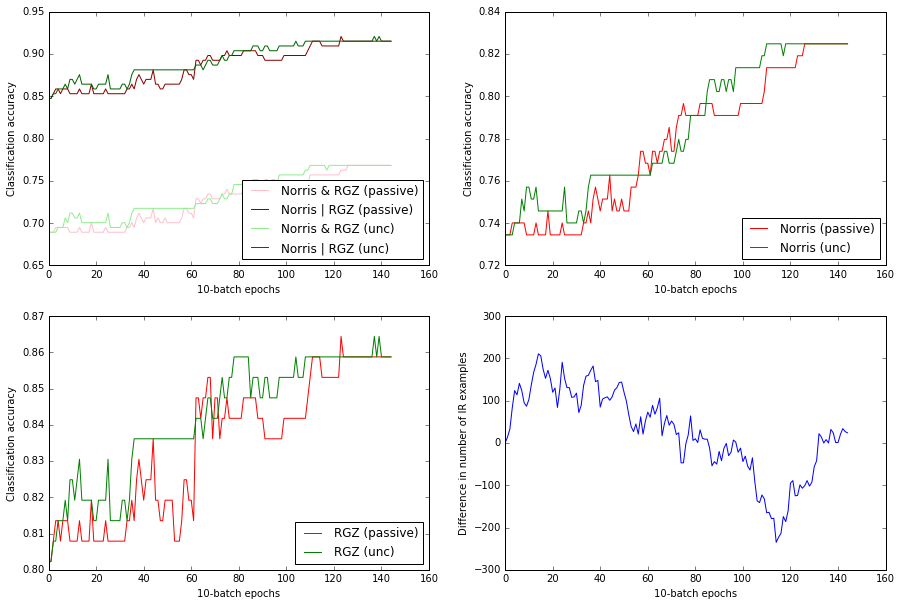

In [98]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)

plt.plot(all_accuracies_random, c='pink')
plt.plot(any_accuracies_random, c='darkred')

plt.plot(all_accuracies_uncsample, c='lightgreen')
plt.plot(any_accuracies_uncsample, c='darkgreen')

plt.xlabel('{}-batch epochs'.format(n_batch))
plt.ylabel('Classification accuracy')

plt.legend(['Norris & RGZ (passive)', 'Norris | RGZ (passive)',
            'Norris & RGZ (unc)', 'Norris | RGZ (unc)'], loc='lower right')

plt.subplot(2, 2, 2)

plt.plot(norris_accuracies_random, c='red')
plt.plot(norris_accuracies_uncsample, c='green')

plt.legend(['Norris (passive)', 'Norris (unc)'], loc='lower right')

plt.xlabel('{}-batch epochs'.format(n_batch))
plt.ylabel('Classification accuracy')

plt.subplot(2, 2, 3)

plt.plot(rgz_accuracies_random, c='red')
plt.plot(rgz_accuracies_uncsample, c='green')

plt.legend(['RGZ (passive)', 'RGZ (unc)'], loc='lower right')

plt.xlabel('{}-batch epochs'.format(n_batch))
plt.ylabel('Classification accuracy')

plt.subplot(2, 2, 4)

plt.plot(numpy.array(n_ir_random) - numpy.array(n_ir_uncsample))

plt.xlabel('{}-batch epochs'.format(n_batch))
plt.ylabel('Difference in number of IR examples')

plt.show()

Conclusion: Uncertainty sampling with entropy doesn't work very well.